# Effect of the Train/test Ratio on the Accuracy of Temperature Forecasting using SARIMA

H0: The train/test ratio has no effect on the accuracy of time series temperature forecasting using SARIMA

H1: The train/test ratio has an effect on the accuracy of time series temperature forecasting using SARIMA

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import statsmodels.api as sm

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

## Preparing the Data

Dataset: https://www.ncdc.noaa.gov/cdo-web/search
1. Daily summaries
2. 01/01/1951 to present
3. Stations
4. Nanjing
5. Add to cart: Nanjing, CN
6. View cart items
7. CSV
8. Select all data
9. Receive in email

In [2]:
temp = pd.read_csv("nanjing_daily_summary.csv")

In [3]:
temp

,STATION,NAME,DATE,PRCP,SNWD,TAVG,TMAX,TMIN
0,CHM00058238,"NANJING, CH",1951-01-01,0.00,NaN,NaN,53.0,38.0
1,CHM00058238,"NANJING, CH",1951-01-02,0.01,NaN,42.0,45.0,39.0
2,CHM00058238,"NANJING, CH",1951-01-03,0.00,NaN,44.0,52.0,40.0
3,CHM00058238,"NANJING, CH",1951-01-04,0.00,NaN,44.0,58.0,34.0
4,CHM00058238,"NANJING, CH",1951-01-05,0.00,NaN,49.0,62.0,40.0
...,...,...,...,...,...,...,...,...
26341,CHM00058238,"NANJING, CH",2023-02-16,0.01,NaN,45.0,50.0,33.0
26342,CHM00058238,"NANJING, CH",2023-02-17,0.00,NaN,49.0,NaN,35.0
26343,CHM00058238,"NANJING, CH",2023-02-18,0.00,NaN,50.0,NaN,NaN
26344,CHM00058238,"NANJING, CH",2023-02-19,0.00,NaN,42.0,56.0,NaN


In [4]:
temp['DATE'] = pd.to_datetime(temp['DATE'])

In [5]:
temp.set_index('DATE', inplace=True)

In [6]:
temp

,STATION,NAME,PRCP,SNWD,TAVG,TMAX,TMIN
DATE,,,,,,,
1951-01-01,CHM00058238,"NANJING, CH",0.00,NaN,NaN,53.0,38.0
1951-01-02,CHM00058238,"NANJING, CH",0.01,NaN,42.0,45.0,39.0
1951-01-03,CHM00058238,"NANJING, CH",0.00,NaN,44.0,52.0,40.0
1951-01-04,CHM00058238,"NANJING, CH",0.00,NaN,44.0,58.0,34.0
1951-01-05,CHM00058238,"NANJING, CH",0.00,NaN,49.0,62.0,40.0
...,...,...,...,...,...,...,...
2023-02-16,CHM00058238,"NANJING, CH",0.01,NaN,45.0,50.0,33.0
2023-02-17,CHM00058238,"NANJING, CH",0.00,NaN,49.0,NaN,35.0
2023-02-18,CHM00058238,"NANJING, CH",0.00,NaN,50.0,NaN,NaN


In [7]:
# remove all the unnecessary columns
temp.drop(["STATION","NAME","PRCP","SNWD", "TMAX", "TMIN"], axis=1, inplace=True)

In [8]:
temp

,TAVG
DATE,
1951-01-01,NaN
1951-01-02,42.0
1951-01-03,44.0
1951-01-04,44.0
1951-01-05,49.0
...,...
2023-02-16,45.0
2023-02-17,49.0
2023-02-18,50.0


In [9]:
# check percentage of missing values
temp.apply(pd.isnull).sum()/temp.shape[0]

TAVG    0.000038
dtype: float64

In [10]:
# check missing values for TAVG
temp[pd.isnull(temp["TAVG"])]
temp

,TAVG
DATE,
1951-01-01,NaN
1951-01-02,42.0
1951-01-03,44.0
1951-01-04,44.0
1951-01-05,49.0
...,...
2023-02-16,45.0
2023-02-17,49.0
2023-02-18,50.0


In [11]:
# only first row missing, can remove
temp = temp.drop("1951-01-01")

In [12]:
temp

,TAVG
DATE,
1951-01-02,42.0
1951-01-03,44.0
1951-01-04,44.0
1951-01-05,49.0
1951-01-06,46.0
...,...
2023-02-16,45.0
2023-02-17,49.0
2023-02-18,50.0


In [13]:
# Converting daily TAVG to monthly mean TAVG
temp = temp.resample('M').mean()

In [14]:
temp

,TAVG
DATE,
1951-01-31,36.066667
1951-02-28,38.678571
1951-03-31,45.580645
1951-04-30,54.900000
1951-05-31,69.258065
...,...
2022-10-31,62.838710
2022-11-30,57.000000
2022-12-31,38.741935


In [15]:
# convert TAVG from farenheit to celsius
temp['TAVG'] = (temp['TAVG'] - 32) * 5/9

In [16]:
temp

,TAVG
DATE,
1951-01-31,2.259259
1951-02-28,3.710317
1951-03-31,7.544803
1951-04-30,12.722222
1951-05-31,20.698925
...,...
2022-10-31,17.132616
2022-11-30,13.888889
2022-12-31,3.745520


In [17]:
# checking for correct datatypes
temp.dtypes

TAVG    float64
dtype: object

In [18]:
temp.index

DatetimeIndex(['1951-01-31', '1951-02-28', '1951-03-31', '1951-04-30',
               '1951-05-31', '1951-06-30', '1951-07-31', '1951-08-31',
               '1951-09-30', '1951-10-31',
               ...
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
               '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
               '2023-01-31', '2023-02-28'],
              dtype='datetime64[ns]', name='DATE', length=866, freq='M')

In [19]:
# according to data set documentation:
# "Note: 9’s in a field (e.g.9999) indicate missing data or data that has not been received"
# check if there is any 9999 value in the data set
temp.apply(lambda x: (x==9999).sum())

TAVG    0
dtype: int64

<AxesSubplot:xlabel='DATE'>

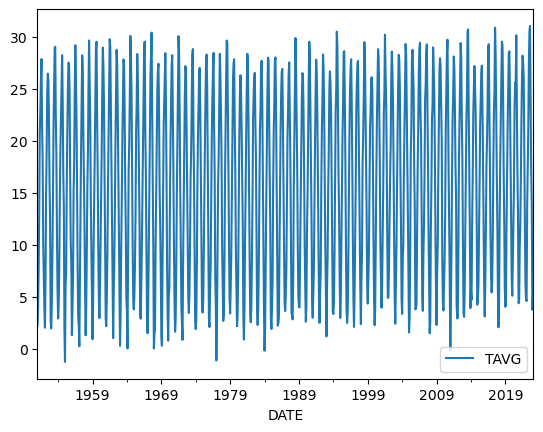

In [20]:
temp.plot()

## Normalisation of data

In [21]:
# Create a scaler object and fit it to the temperature column
scaler = MinMaxScaler()
scaler.fit(temp[['TAVG']])

# Transform the temperature column using the fitted scaler
temp['TAVG'] = scaler.transform(temp[['TAVG']])

<AxesSubplot:xlabel='DATE'>

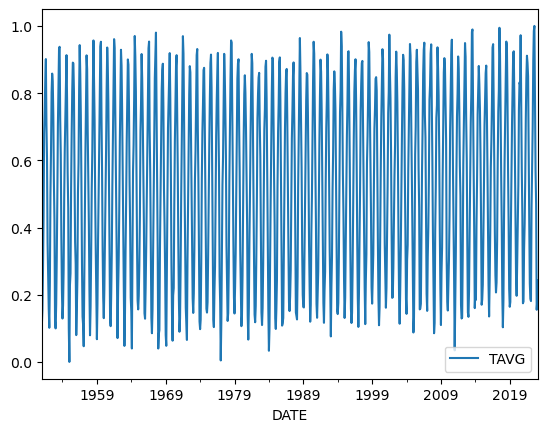

In [22]:
temp.plot()

## ACF and PACF
The ACF and PACF are used to determine if an AR (p) or MA (q) model is appropriated and determine possible candidate models.

ACF measures the correlation between a time series and its lagged values, while PACF measures the correlation between a time series and its lagged values, controlling for the effect of the intervening lags.

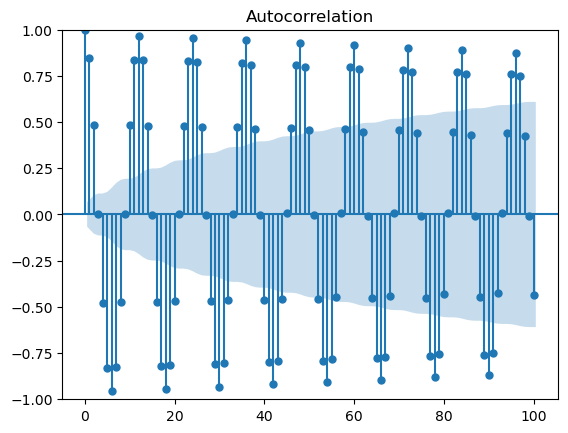

In [23]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(temp, lags=100)
plt.show()

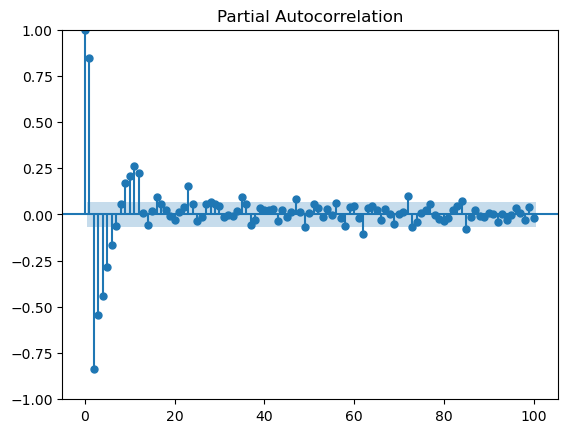

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(temp, lags=100, method='ywm')
plt.show()

## Splitting the data

In [25]:
# 30:70, 40:60, 50:50, 60:40, 70:30, 80:20, 90:10, Research train/test split
train3070, test3070 = train_test_split(temp['TAVG'], test_size=0.7, random_state=42, shuffle=False)
train4060, test4060 = train_test_split(temp['TAVG'], test_size=0.59, random_state=42, shuffle=False)
train5050, test5050 = train_test_split(temp['TAVG'], test_size=0.5, random_state=42, shuffle=False)
train6040, test6040 = train_test_split(temp['TAVG'], test_size=0.4, random_state=42, shuffle=False)
train7030, test7030 = train_test_split(temp['TAVG'], test_size=0.298, random_state=42, shuffle=False)
train8020, test8020 = train_test_split(temp['TAVG'], test_size=0.2, random_state=42, shuffle=False)
train9010, test9010 = train_test_split(temp['TAVG'], test_size=0.1, random_state=42, shuffle=False)

# Research train/test split
# Train: January 1980 to December 2015, Test: January 2015 to December 2017
trainR = temp.loc["1980-1-31":"2015-12-31"]
testR = temp.loc["2015-1-31":"2017-12-31"]

in the study, the researchers utilised a 95:5 train test split, which is typically advised against

## Using auto_arima to determine parameters

In [26]:
# 30:70 parameters

# use auto_arima to determine SARIMA parameters
sarima_model = pm.auto_arima(train3070, seasonal=True, m=12, 
                             stepwise=True, suppress_warnings=True,
                             error_action="ignore", max_order=None,
                             trace=True)

# print out the selected model parameters
print(sarima_model.order)
print(sarima_model.seasonal_order)

# create and fit SARIMA model using the selected parameters
model3070 = SARIMAX(train3070, order=sarima_model.order, seasonal_order=sarima_model.seasonal_order)
results3070 = model3070.fit()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-813.845, Time=1.34 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=87.396, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-329.847, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=458.491, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-743.222, Time=0.97 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=-806.683, Time=2.73 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=-805.212, Time=2.66 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-792.420, Time=0.28 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=-596.332, Time=2.59 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=-742.153, Time=2.09 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=-298.131, Time=1.85 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-796.927, Time=1.11 sec
 ARIMA(2,0,1)(1,0,1)[12] interce

 This problem is unconstrained.



At iterate    5    f= -1.32411D+00    |proj g|=  1.23040D+01

At iterate   10    f= -1.56398D+00    |proj g|=  1.44424D-01

At iterate   15    f= -1.59330D+00    |proj g|=  1.36339D-01

At iterate   20    f= -1.59894D+00    |proj g|=  1.89048D-01

At iterate   25    f= -1.60250D+00    |proj g|=  4.25336D-01

At iterate   30    f= -1.60331D+00    |proj g|=  2.51187D-02

At iterate   35    f= -1.60331D+00    |proj g|=  5.88738D-03

At iterate   40    f= -1.60335D+00    |proj g|=  5.15062D-03

At iterate   45    f= -1.60349D+00    |proj g|=  1.07788D-01

At iterate   50    f= -1.60446D+00    |proj g|=  2.34079D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/jason/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [27]:
# 40:60 parameters
sarima_model = pm.auto_arima(train4060, seasonal=True, m=12, 
                             stepwise=True, suppress_warnings=True,
                             error_action="ignore", max_order=None,
                             trace=True)

print(sarima_model.order)
print(sarima_model.seasonal_order)

model4060 = SARIMAX(train4060, order=sarima_model.order, seasonal_order=sarima_model.seasonal_order)
results4060 = model4060.fit()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=114.274, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-477.529, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=627.653, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-242.623, Time=0.04 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-1184.545, Time=1.10 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-990.609, Time=0.49 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=-1184.735, Time=2.03 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=-1075.897, Time=1.71 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=2.88 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-1175.234, Time=3.65 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=-1172.120, Time=2.81 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=-1172.858, Time=2.76 sec
 ARIMA(0,0,2)(2,0,1)[12] interc

/Users/jason/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f= -1.59028D+00    |proj g|=  6.48020D-01

At iterate   10    f= -1.62500D+00    |proj g|=  2.95634D+00

At iterate   15    f= -1.62962D+00    |proj g|=  6.68399D-02

At iterate   20    f= -1.63031D+00    |proj g|=  7.34037D-01

At iterate   25    f= -1.63103D+00    |proj g|=  1.16398D-02

At iterate   30    f= -1.63117D+00    |proj g|=  2.28592D-01

At iterate   35    f= -1.63121D+00    |proj g|=  2.55380D-02

At iterate   40    f= -1.63255D+00    |proj g|=  1.88268D-01

At iterate   45    f= -1.67197D+00    |proj g|=  3.65957D-01

At iterate   50    f= -1.67262D+00    |proj g|=  1.08131D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/jason/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
# 50:50 parameters
sarima_model = pm.auto_arima(train5050, seasonal=True, m=12, 
                             stepwise=True, suppress_warnings=True,
                             error_action="ignore", max_order=None,
                             trace=True)

print(sarima_model.order)
print(sarima_model.seasonal_order)

model5050 = SARIMAX(train5050, order=sarima_model.order, seasonal_order=sarima_model.seasonal_order)
results5050 = model5050.fit()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-819.832, Time=1.98 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=137.876, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-601.756, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=762.891, Time=0.05 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=2.83 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=2.04 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=4.38 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=98.250, Time=10.16 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=inf, Time=5.52 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=inf, Time=6.96 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=-174.088, Time=6.08 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-1466.160, Time=1.70 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-847.299, Tim

/Users/jason/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f= -1.63893D+00    |proj g|=  5.06124D-01

At iterate   10    f= -1.69249D+00    |proj g|=  3.54401D+00

At iterate   15    f= -1.69888D+00    |proj g|=  1.51417D-01

At iterate   20    f= -1.70098D+00    |proj g|=  1.45406D+00

At iterate   25    f= -1.70268D+00    |proj g|=  3.76985D-02

At iterate   30    f= -1.70372D+00    |proj g|=  3.94163D-01

At iterate   35    f= -1.70550D+00    |proj g|=  2.27389D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     51      1     0     0   1.214D-03  -1.706D+00
  F =  -1.7055019902885693     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

In [29]:
# 60:40 parameters
sarima_model = pm.auto_arima(train6040, seasonal=True, m=12, 
                             stepwise=True, suppress_warnings=True,
                             error_action="ignore", max_order=None,
                             trace=True)

print(sarima_model.order)
print(sarima_model.seasonal_order)

model6040 = SARIMAX(train6040, order=sarima_model.order, seasonal_order=sarima_model.seasonal_order)
results6040 = model6040.fit()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-1819.299, Time=2.81 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=157.408, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-743.650, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=912.254, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-1569.653, Time=2.24 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-1542.370, Time=1.83 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=-1815.902, Time=6.39 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=-1838.159, Time=7.58 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=-1496.653, Time=5.16 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=6.61 sec
 ARIMA(1,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=4.35 sec
 ARIMA(2,0,1)(1,0,2)[12] intercept   : AIC=-1732.621, Time=4.72 sec
 ARIMA(3,0,2)(1,0,2)[12] intercept   : AIC=-1707.092, Time=4.35 sec
 ARIMA(2,0,3)(1,0,2)[12] int

 This problem is unconstrained.



At iterate    5    f= -1.61530D+00    |proj g|=  1.19512D+01

At iterate   10    f= -1.73205D+00    |proj g|=  9.93354D-02

At iterate   15    f= -1.74807D+00    |proj g|=  8.85916D-01

At iterate   20    f= -1.74888D+00    |proj g|=  1.78824D-01

At iterate   25    f= -1.75096D+00    |proj g|=  1.69733D-01

At iterate   30    f= -1.75533D+00    |proj g|=  5.29558D-01

At iterate   35    f= -1.75588D+00    |proj g|=  5.01363D-02

At iterate   40    f= -1.75704D+00    |proj g|=  5.25914D-01

At iterate   45    f= -1.75768D+00    |proj g|=  2.74904D-01

At iterate   50    f= -1.75827D+00    |proj g|=  5.44667D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/jason/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [30]:
# 70:30 parameters
sarima_model = pm.auto_arima(train7030, seasonal=True, m=12, 
                             stepwise=True, suppress_warnings=True,
                             error_action="ignore", max_order=None,
                             trace=True)

print(sarima_model.order)
print(sarima_model.seasonal_order)

model7030 = SARIMAX(train7030, order=sarima_model.order, seasonal_order=sarima_model.seasonal_order)
results7030 = model7030.fit()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.54 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=179.664, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-879.218, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1076.425, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-450.127, Time=0.19 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-2146.395, Time=1.44 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-1826.465, Time=1.22 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=-1937.351, Time=2.78 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-2088.320, Time=3.49 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-1122.892, Time=2.00 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=-2003.936, Time=2.51 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=-1875.058, Time=3.55 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-2149.311, Time=1.18 sec
 ARIMA(0,0,0)(0,0,1)[1

/Users/jason/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


  ys=-3.049E+00  -gs= 9.416E-01 BFGS update SKIPPED

At iterate   10    f= -9.74505D-01    |proj g|=  3.65228D+00

At iterate   15    f= -1.09947D+00    |proj g|=  8.79220D-01

At iterate   20    f= -1.48953D+00    |proj g|=  1.75461D+00

At iterate   25    f= -1.67683D+00    |proj g|=  2.90938D-01

At iterate   30    f= -1.74465D+00    |proj g|=  3.60382D-02

At iterate   35    f= -1.75910D+00    |proj g|=  2.75606D-01

At iterate   40    f= -1.75913D+00    |proj g|=  7.19646D-03

At iterate   45    f= -1.75913D+00    |proj g|=  4.74576D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     49     95      1     1

In [31]:
# 80:20 parameters
sarima_model = pm.auto_arima(train8020, seasonal=True, m=12, 
                             stepwise=True, suppress_warnings=True,
                             error_action="ignore", max_order=None,
                             trace=True)

print(sarima_model.order)
print(sarima_model.seasonal_order)

model8020 = SARIMAX(train8020, order=sarima_model.order, seasonal_order=sarima_model.seasonal_order)
results8020 = model8020.fit()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.21 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=202.366, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-981.179, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1237.005, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-516.427, Time=0.10 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-2406.022, Time=1.73 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-2051.522, Time=0.84 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=-2197.599, Time=4.03 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-2405.804, Time=4.21 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-1269.377, Time=1.50 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=-2273.192, Time=2.58 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=5.34 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-2438.275, Time=1.30 sec
 ARIMA(0,0,0)(0,0,1)[12] int

/Users/jason/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate    5    f= -1.10712D+00    |proj g|=  4.93391D+00

At iterate   10    f= -1.27293D+00    |proj g|=  1.34125D-01

At iterate   15    f= -1.36489D+00    |proj g|=  3.78390D+00

At iterate   20    f= -1.51590D+00    |proj g|=  2.53495D+00

At iterate   25    f= -1.55696D+00    |proj g|=  9.77637D-01

At iterate   30    f= -1.62648D+00    |proj g|=  1.04375D+00

At iterate   35    f= -1.67342D+00    |proj g|=  1.60595D-01

At iterate   40    f= -1.75361D+00    |proj g|=  1.95601D+00

At iterate   45    f= -1.77679D+00    |proj g|=  2.38794D-01

At iterate   50    f= -1.77684D+00    |proj g|=  1.16369D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/jason/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [32]:
# 90:10 parameters
sarima_model = pm.auto_arima(train9010, seasonal=True, m=12, 
                             stepwise=True, suppress_warnings=True,
                             error_action="ignore", max_order=None,
                             trace=True)

print(sarima_model.order)
print(sarima_model.seasonal_order)

model9010 = SARIMAX(train9010, order=sarima_model.order, seasonal_order=sarima_model.seasonal_order)
results9010 = model9010.fit()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=223.255, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-1087.040, Time=0.97 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1397.713, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-575.243, Time=0.15 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-2403.363, Time=2.46 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-2324.198, Time=1.64 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=-2633.516, Time=5.14 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=-2525.287, Time=3.60 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=7.56 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-2674.548, Time=5.34 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-1408.083, Time=2.96 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=-2652.847, Time=3.69 sec
 ARIMA(1,0,1)(1,0,2)[12] int

/Users/jason/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


  ys=-1.799E+00  -gs= 1.104E+00 BFGS update SKIPPED

At iterate    5    f= -1.00243D+00    |proj g|=  1.96021D+00

At iterate   10    f= -1.30448D+00    |proj g|=  2.48884D+00

At iterate   15    f= -1.40332D+00    |proj g|=  1.20241D-01

At iterate   20    f= -1.45712D+00    |proj g|=  2.10892D+00

At iterate   25    f= -1.52628D+00    |proj g|=  2.66117D-01

At iterate   30    f= -1.57187D+00    |proj g|=  1.45440D+00
  ys=-1.496E-01  -gs= 4.894E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     60      1     2     0   4.143D+00  -1.619D+00
  F =  -1.6189172351938923     

CONVERGE

In [33]:
# Research parameters
sarima_model = pm.auto_arima(trainR, seasonal=True, m=12, 
                             stepwise=True, suppress_warnings=True,
                             error_action="ignore", max_order=None,
                             trace=True)

print(sarima_model.order)
print(sarima_model.seasonal_order)

modelR = SARIMAX(trainR, order=sarima_model.order, seasonal_order=sarima_model.seasonal_order)
resultsR = modelR.fit()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-1188.161, Time=2.21 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=114.748, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-604.202, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=784.353, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-910.727, Time=1.72 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-1272.958, Time=1.47 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-662.658, Time=0.41 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=-1362.214, Time=5.22 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=-1349.064, Time=6.00 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=-1383.076, Time=3.42 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=-1277.716, Time=0.98 sec
 ARIMA(1,0,2)(2,0,1)[12] intercept   : AIC=-1397.759, Time=3.90 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-1430.052, Time=1.75 sec
 ARIMA(1,0,2)(0,0,

/Users/jason/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/jason/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate    5    f= -8.35704D-01    |proj g|=  2.33040D+00
  ys=-1.559E+00  -gs= 8.878E-01 BFGS update SKIPPED

At iterate   10    f= -1.04039D+00    |proj g|=  6.22833D-01

At iterate   15    f= -1.43213D+00    |proj g|=  4.99018D-01

At iterate   20    f= -1.58657D+00    |proj g|=  1.20468D-01

At iterate   25    f= -1.61076D+00    |proj g|=  2.45775D+00

At iterate   30    f= -1.71841D+00    |proj g|=  8.60304D-01

At iterate   35    f= -1.76435D+00    |proj g|=  6.05936D-01

At iterate   40    f= -1.76966D+00    |proj g|=  6.03391D-01
  ys=-2.361E-05  -gs= 6.651E-06 BFGS update SKIPPED

At iterate   45    f= -1.77035D+00    |proj g|=  1.00406D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function v

## Plotting predicted values against real values

In [34]:
# forecast test data
pred3070 = results3070.forecast(steps=len(test3070))
pred4060 = results4060.forecast(steps=len(test4060))
pred5050 = results5050.forecast(steps=len(test5050))
pred6040 = results6040.forecast(steps=len(test6040))
pred7030 = results7030.forecast(steps=len(test7030))
pred8020 = results8020.forecast(steps=len(test8020))
pred9010 = results9010.forecast(steps=len(test9010))
predR = resultsR.forecast(steps=len(testR))

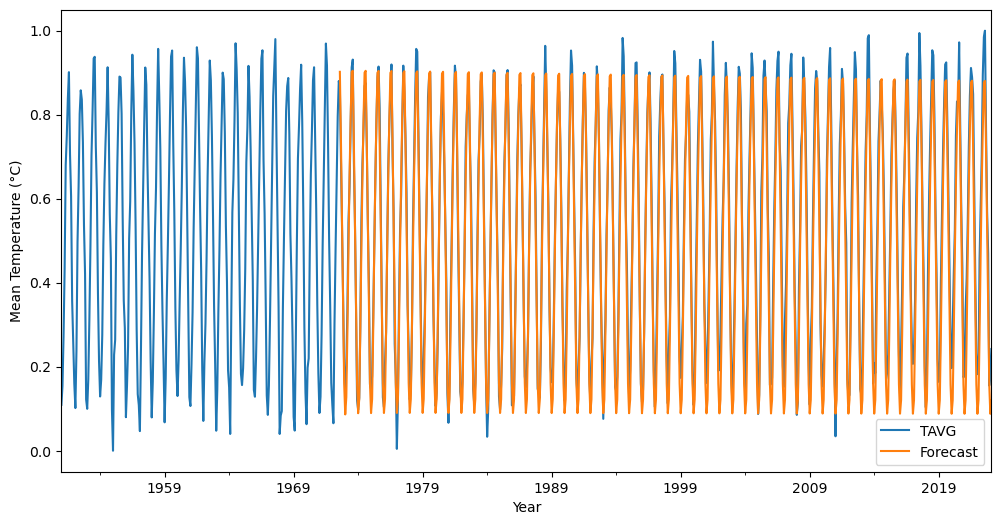

In [35]:
# 30:70 plot
ax = temp.plot(label='Observed', figsize=(12,6))
pred3070.plot(ax=ax, label='Forecast')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Temperature (°C)')
ax.legend()

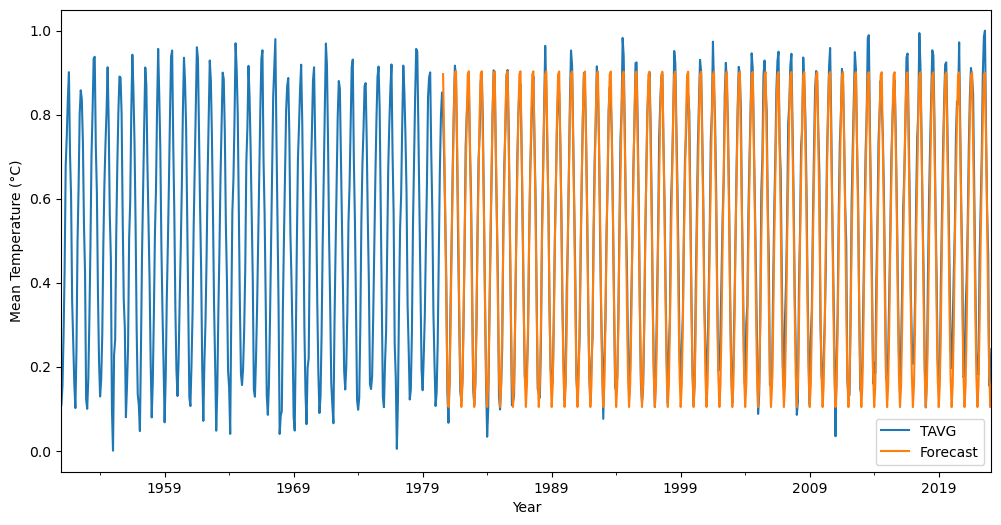

In [36]:
# 40:60 plot
ax = temp.plot(label='Observed', figsize=(12,6))
pred4060.plot(ax=ax, label='Forecast')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Temperature (°C)')
ax.legend()

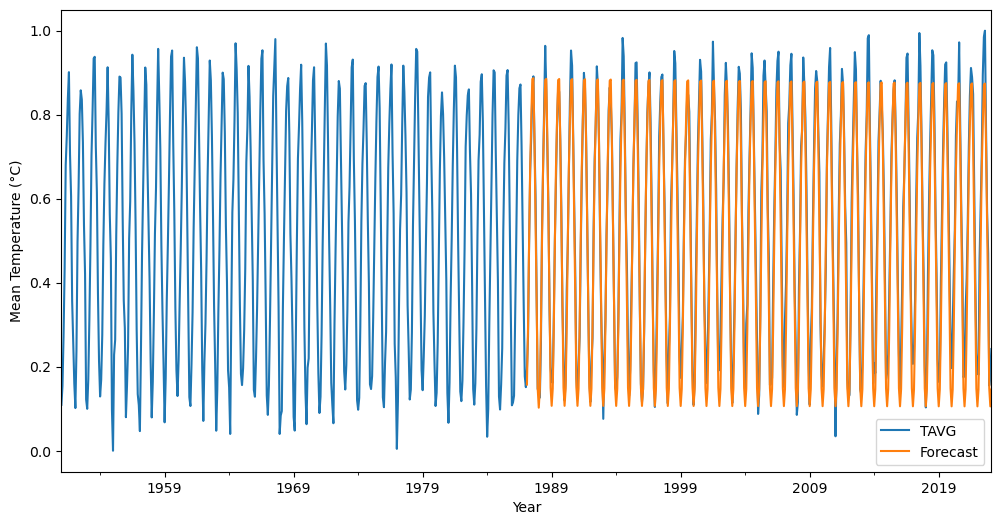

In [37]:
# 50:50 plot
ax = temp.plot(label='Observed', figsize=(12,6))
pred5050.plot(ax=ax, label='Forecast')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Temperature (°C)')
ax.legend()

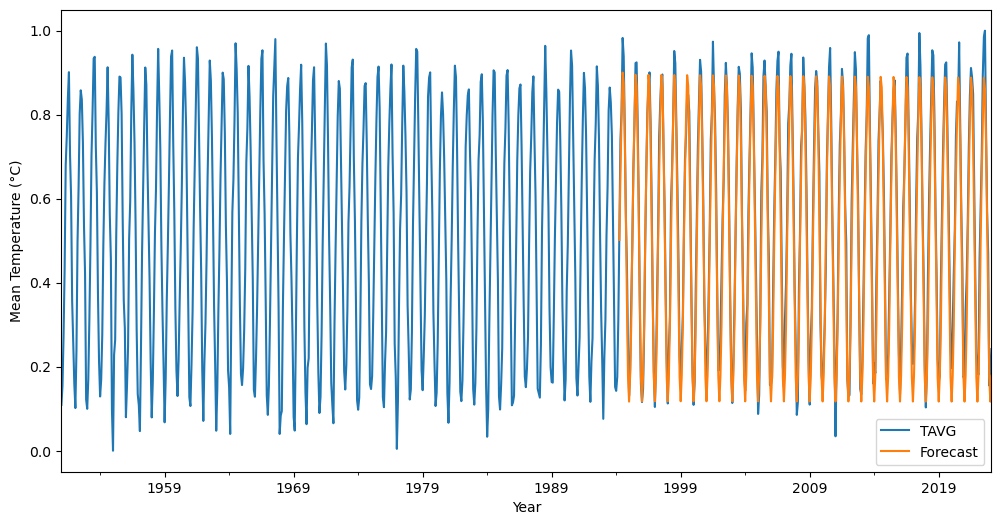

In [38]:
# 60:40 plot
ax = temp.plot(label='Observed', figsize=(12,6))
pred6040.plot(ax=ax, label='Forecast')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Temperature (°C)')
ax.legend()

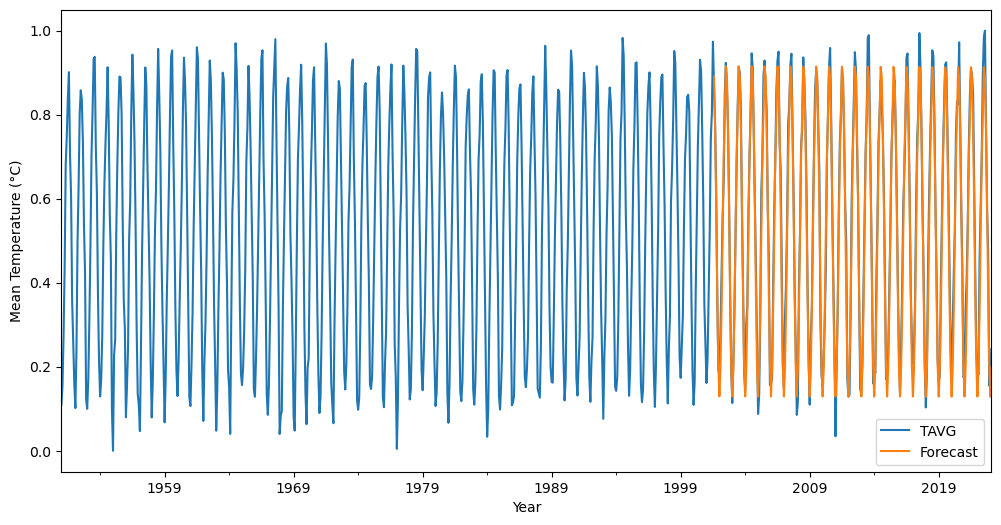

In [39]:
# 70:30 plot
ax = temp.plot(label='Observed', figsize=(12,6))
pred7030.plot(ax=ax, label='Forecast')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Temperature (°C)')
ax.legend()

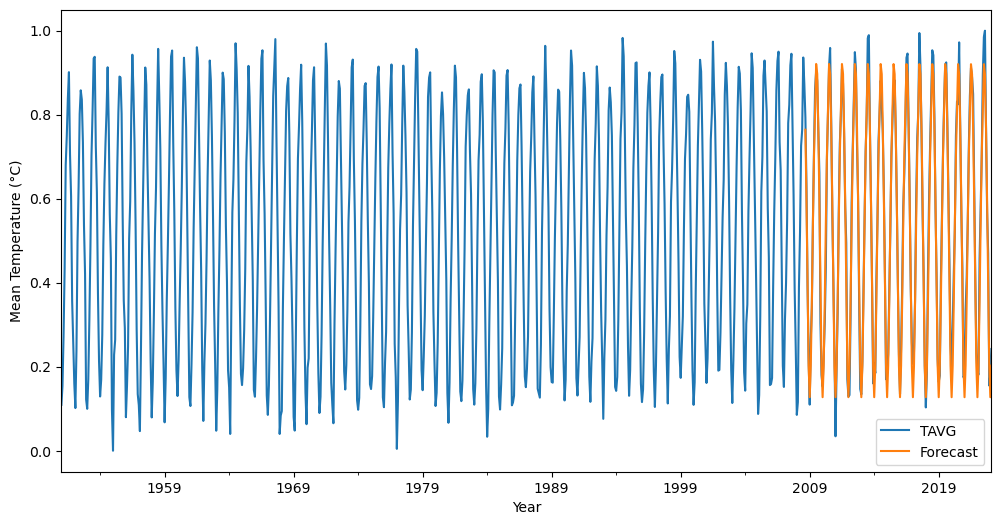

In [40]:
# 80:20 plot
ax = temp.plot(label='Observed', figsize=(12,6))
pred8020.plot(ax=ax, label='Forecast')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Temperature (°C)')
ax.legend()

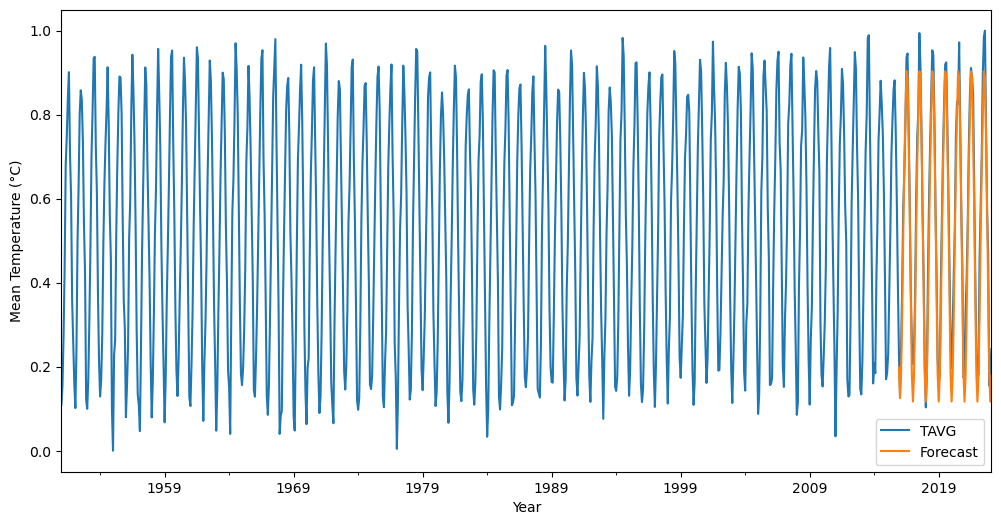

In [41]:
# 90:10 plot
ax = temp.plot(label='Observed', figsize=(12,6))
pred9010.plot(ax=ax, label='Forecast')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Temperature (°C)')
ax.legend()

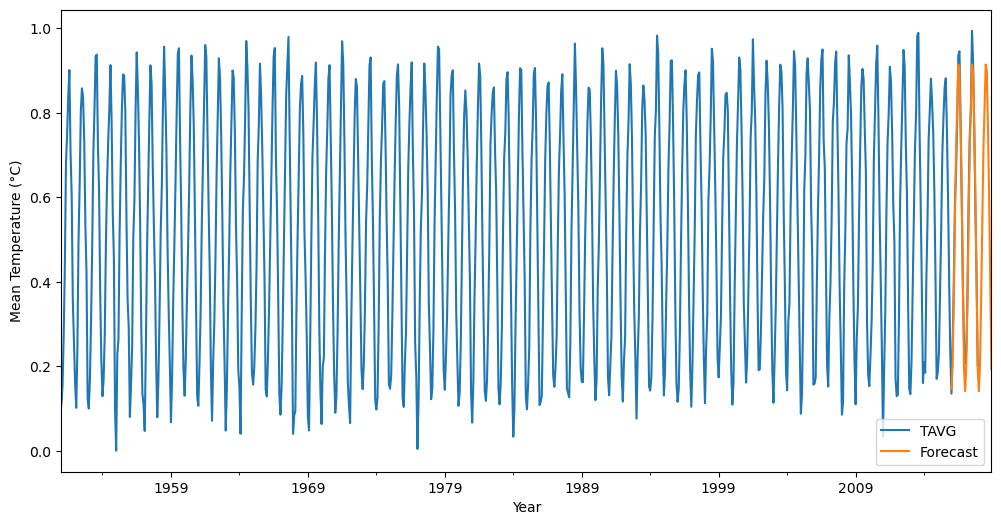

In [42]:
# Research plot

tempR = temp.loc[:"2017-12-31"]

ax = tempR.plot(label='Observed', figsize=(12,6))
predR.plot(ax=ax, label='Forecast')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Temperature (°C)')
ax.legend()

## Calculating MAPE

In [43]:
# 30:70 MAPE

mape3070 = mean_absolute_percentage_error(test3070, pred3070)
print("30:70 MAPE: ", mape3070)

30:70 MAPE:  0.16759460842528792


In [44]:
# 40:60 MAPE

mape4060 = mean_absolute_percentage_error(test4060, pred4060)
print("40:60 MAPE: ", mape4060)

40:60 MAPE:  0.11532772533938032


In [45]:
# 50:50 MAPE

mape5050 = mean_absolute_percentage_error(test5050, pred5050)
print("50:50 MAPE: ", mape5050)

50:50 MAPE:  0.12738393339338286


In [46]:
# 60:40 MAPE

mape6040 = mean_absolute_percentage_error(test6040, pred6040)
print("60:40 MAPE: ", mape6040)

60:40 MAPE:  0.11913506928415395


In [47]:
# 70:30 MAPE

mape7030 = mean_absolute_percentage_error(test7030, pred7030)
print("70:30 MAPE: ", mape7030)

70:30 MAPE:  0.10626904943561732


In [48]:
# 80:20 MAPE

mape8020 = mean_absolute_percentage_error(test8020, pred8020)
print("80:20 MAPE: ", mape8020)

80:20 MAPE:  0.10283651641287264


In [49]:
# 90:10 MAPE

mape9010 = mean_absolute_percentage_error(test9010, pred9010)
print("90:10 MAPE: ", mape9010)

90:10 MAPE:  0.1214013341401273


In [50]:
# Research MAPE

mapeR = mean_absolute_percentage_error(testR, predR)
print("Research MAPE: ", mapeR)

Research MAPE:  0.06740354623113598


In [51]:
# Research MSE

mse = mean_squared_error(testR, predR)
print("Research MSE: ", mse)

# in the paper, the MSE is 0.89

Research MSE:  0.0011618535830010186


## Plotting MAPE vs Train Test Split Ratio

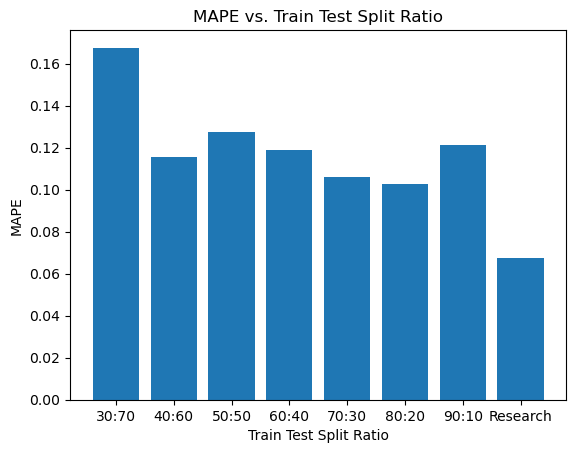

In [52]:
# Define the data
x_axis = ['30:70', '40:60', '50:50', '60:40', '70:30', '80:20', '90:10', 'Research']
y_axis = [mape3070, mape4060, mape5050, mape6040, mape7030, mape8020, mape9010, mapeR]

# Create the chart
plt.bar(x_axis, y_axis)

# Set the chart title and axis labels
plt.title('MAPE vs. Train Test Split Ratio')
plt.xlabel('Train Test Split Ratio')
plt.ylabel('MAPE')

# Show the chart
plt.show()

## Statistical Significance Test: Simple Linear Regression Analysis

In [55]:
x_axis = np.array([30, 40, 50, 60, 70, 80, 90, 92])
y_axis = [mape3070, mape4060, mape5050, mape6040, mape7030, mape8020, mape9010, mapeR]

# Add a constant to the predictor variable (train_test_ratio)
x_axis = sm.add_constant(x_axis)

# Create a linear regression model and fit it to the data
model = sm.OLS(y_axis, x_axis).fit()

# Print a summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     8.036
Date:                Sun, 09 Apr 2023   Prob (F-statistic):             0.0298
Time:                        01:04:13   Log-Likelihood:                 21.207
No. Observations:                   8   AIC:                            -38.41
Df Residuals:                       6   BIC:                            -38.25
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1748      0.022      7.980      0.0

/Users/jason/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
